# MNIST 

In this example, we consider the classic machine learning dataset MNIST and the task of classifying handwritten digits. By modern computer vision standards this dataset is considered small, yet it is sufficiently large that many standard classifiers (e.g. those in the Python package `sklearn`) require significant time to train a model. Nonetheless, [Epsilon](http://epopt.io/) is able to fit a model that achieves near state-of-the-art accuracy in a few minutes. 

<img src="mnist.png" />

The standard task is to train a multiclass classifier that can correctly identify digits from their pixel intensity values. For the purposes of this example, we simplify this task slightly and instead consider the binary classification task of even vs. odd. To build our classifier we have a training set of 60K images of dimension 28x28 and a test set of 10K images.

In [1]:
%matplotlib inline
import io
import urllib
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import epopt as ep

mnist = np.load(io.BytesIO(urllib.urlopen("http://epopt.s3.amazonaws.com/mnist.npz").read()))

## Hinge loss and support vector machines

Mathematically we will set up our problem with a set of training examples $(X, y)$ where $X$ is a matrix containing $m$ training examples with $n$ input features ($X \in \mathbb{R}^{m \times n}$) and $y \in \{-1,1\}^m$ is the set of binary labels. Given this training set, we will fit the parameters of our model by minimizing some loss function
$$
\DeclareMathOperator{\minimize}{minimize} \minimize \;\; \ell(\theta; X, y), 
$$
where $\theta \in \mathbb{R}^n$ denotes model parameters. A natural loss for classification tasks is the 0-1 loss: given a classifier, for each example we incur a penalty of 1 for each incorrect prediction and 0 otherwise. This loss function is nonconvex and so instead we minimize the *hinge loss*
$$
\ell(\theta; X, y) = \sum_{i=1}^m \max \{0, 1 - y_i(\theta^Tx_i) \}.
$$
Conceptually, the hinge loss is in fact the tightest possible convex surrogate for the 0-1 loss as can be seen from the following picture:


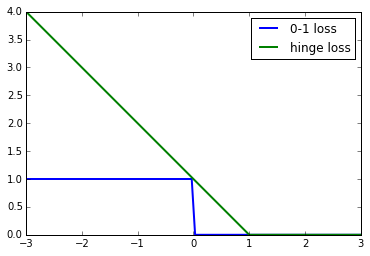

In [22]:
z = np.linspace(-3,3, 100)
plt.plot(z, z < 0, linewidth=2)
plt.plot(z, np.maximum(0, 1 - z), linewidth=2)
_ = plt.legend(("0-1 loss", "hinge loss"))

In order to minimize this function using CVXPY and Epsilon, we must write down its definition which is a single line of Python. For convenience, Epsilon provides the `hinge_loss()` function as well as several others, see [`functions.py`](https://github.com/mwytock/epsilon/blob/master/python/epopt/functions.py) for more details.

In [2]:
def hinge_loss(theta, X, y):
    return cp.sum_entries(cp.max_elemwise(1 - sp.diags([y],[0])*X*theta, 0))

Then, we define the parameters formulate the optimization problem and solve. We also add a bit of $\ell_2$-regularization on the parameter vector $\theta$ to keep the values from getting too large. The final optimization problem is
$$
\minimize \;\; \ell(\theta; X, y) + \lambda \|\theta\|_2^2
$$

In [2]:
# Problem data
X = mnist["X"] / 255. 
y = (mnist["Y"].ravel() % 2 == 0)*2-1  # convert labels to {-1,1}
Xtest = mnist["Xtest"] / 255.
ytest = (mnist["Ytest"].ravel() % 2 == 0)*2-1

# Parameters
m, n = X.shape
theta = cp.Variable(n)
lam = 1

# Form problem with CVXPY and solve with Epsilon
f = ep.hinge_loss(theta, X, y) + lam*cp.sum_squares(theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, verbose=True)

# Get solution and evaluate 0-1 error
def error(x, y):    
    return 1 - np.sum(x == y) / float(len(x))

theta0 = np.ravel(theta.value)
print "Train error:", error((X.dot(theta0)>0)*2-1, y)
print "Test error:", error((Xtest.dot(theta0)>0)*2-1, ytest)

Epsilon 0.2.4
Compiled prox-affine form:
objective:
  add(
    sum_hinge(var(x)),
    sum_square(var(y)))

constraints:
  zero(add(add(dense(a)*1.00, scalar(-1.00)*dense(B)*var(y)), scalar(-1.00)*var(x)))
Epsilon compile time: 1.3997 seconds

iter=0 residuals primal=1.52e+02 [2.47e+00] dual=1.92e+02 [1.55e+00]
iter=70 residuals primal=8.04e-01 [6.23e+00] dual=1.13e+00 [1.28e+00]
Epsilon solve time: 18.1032 seconds
Train error: 0.0961833333333
Test error: 0.0979


Thus, a simple linear classifier on pixel intensities achieves a 9.8% error rate on this task. This forms a reasonable baseline, but raw pixel values are in fact poor predictors and we can do much better by considering a nonlinear decision functions which we explore next. 

First, its worth noting that the hinge loss also naturally arises in the derivation of  [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine). In addition, SVMs allow efficient learning of non-linear classification boundaries via their dual formulation and the "kernel trick". In fact, SVMs with Gaussian kernel  
$$ k(x, x') = \exp\left( \frac{-\|x - x'\|^2}{2\sigma^2}  \right) $$
are known to perform very well on MNIST.

Unfortunately as the size of the training set is 60K, explicitly instantiating the kernel matrix (60K x 60K) is prohibitively expensive for this problem. Instead, we will use a recent method based on random Fourier features which approximates the kernel distance function.

## Non-linear classifier using random Fourier features

Rather remarkably, it turns out that transforming the input data points as
$$

$$
for details see Rahimi and Recht, Random Features for Large-scale Kernel Machi

The paritulcar application of this idea to the MNIST dataset is based loosely on the implementation from [this paper](least squares revisited) which has code available [here](github.com)

In [37]:
def median_dist(X):
    """Compute the approximate median distance by sampling pairs."""
    k = 1<<20
    i = np.random.randint(0, Xp.shape[0], k)
    j = np.random.randint(0, Xp.shape[0], k)
    return np.sqrt(np.median(np.sum((Xp[i,:] - Xp[j,:])**2, axis=1)))
    
def pca(X, dim):
    """Perform centered PCA."""
    X = X - X.mean(axis=0)
    return LA.eigh(X.T.dot(X))[1][:,-dim:]

# PCA and median trick
np.random.seed(0)
V = pca(mnist["X"], 50)
X = mnist["X"].dot(V)
sigma = median_dist(X)

# Random features
n = 4000
W = np.random.randn(Xp.shape[1], n) / sigma
b = np.random.uniform(0, 2*np.pi, n)
X = np.cos(X.dot(W) + b)
Xtest = np.cos(mnist["Xtest"].dot(V).dot(W) + b)

Given our transformed dataset, the next step is to fit the classifier. We apply the `hinge_loss()` function discussed above along with some regularization. 

In [41]:
# Parameters
m, n = X.shape
theta = cp.Variable(n)
lam = 10

# Form problem with CVXPY and solve with Epsilon
f = ep.hinge_loss(theta, X, y) + lam*cp.sum_squares(theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, verbose=True)

# Get solution
theta0 = np.ravel(theta.value)
print "Train error:", error((X.dot(theta0)>0)*2-1, y)
print "Test error:", error((Xtest.dot(theta0)>0)*2-1, ytest)

Epsilon 0.2.4
Compiled prox-affine form:
objective:
  add(
    sum_hinge(var(x)),
    sum_square(var(y)))

constraints:
  zero(add(add(dense(a)*1.00, scalar(-1.00)*dense(B)*var(y)), scalar(-1.00)*var(x)))
Epsilon compile time: 9.6309 seconds

iter=0 residuals primal=7.23e+01 [2.47e+00] dual=2.33e+02 [1.07e+00]
iter=80 residuals primal=4.63e-01 [6.14e+00] dual=1.54e+00 [1.59e+00]
Epsilon solve time: 136.8507 seconds
Train error: 0.00685
Test error: 0.0129


## Conclusions